In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [2]:
all_data=pd.read_csv("OMX_Nordic_40.csv")
all_data["Date"]=pd.to_datetime(all_data["Date"],format="%Y-%m-%d")

# remove "High price" and "Low price" columns
all_data = all_data.drop(["High price", "Low price"], axis=1)

display(all_data)

,Date,Closing price
0,2001-12-28,1000.00
1,2002-01-02,983.52
2,2002-01-03,1024.30
3,2002-01-04,1025.50
4,2002-01-07,1020.14
...,...,...
5679,2024-04-04,2747.39
5680,2024-04-05,2738.46
5681,2024-04-08,2757.69
5682,2024-04-09,2739.41


Here I take the log of original data

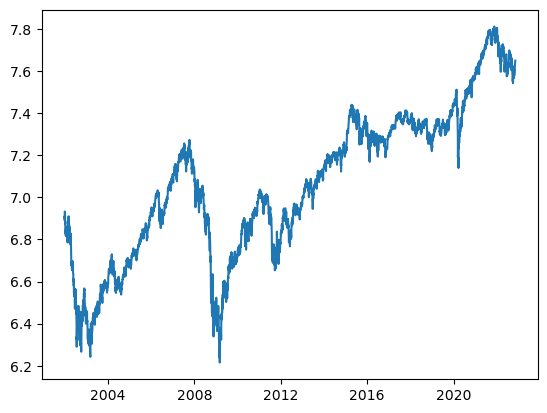

1825


In [3]:
validation_data = all_data["Closing price"].tail(365)
data = all_data["Closing price"].head(-365)
log_data = np.log(data)
plt.plot(all_data["Date"].head(-365), log_data)
plt.show()

print(np.argmin(log_data))

Detrend by a (first order) polynomial

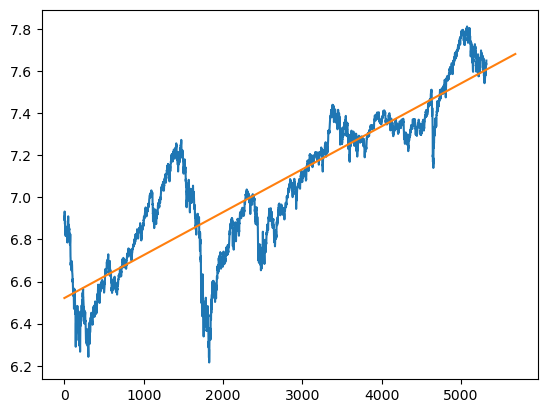

In [4]:
from statsmodels.tsa.tsatools import detrend
trend_deg = 1

# log_data_detrended = detrend(log_data, order=trend_deg)
# plt.plot(all_data["Date"].head(-365), log_data - log_data_detrended)
# plt.plot(all_data["Date"].head(-365), log_data)
# plt.show()

poly = np.polyfit(np.arange(len(log_data)), log_data, trend_deg)
plt.plot(log_data)
plt.plot(np.polyval(poly, np.arange(len(log_data) + 365)))
plt.show()

log_data = log_data - np.polyval(poly, np.arange(len(log_data)))

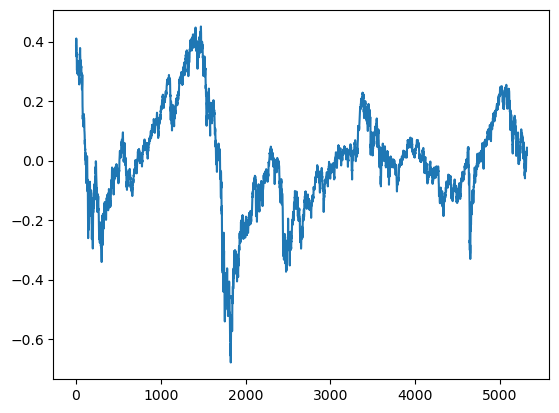

In [5]:
plt.plot(log_data)
plt.show()

## Differencing twice and apply ARMA

In [6]:
diff_log_data = log_data.diff().diff().dropna()

# ADF test
from statsmodels.tsa.stattools import adfuller
result = adfuller(diff_log_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -23.205031
p-value: 0.000000


In [7]:
# KPSS test
from statsmodels.tsa.stattools import kpss
result = kpss(diff_log_data)
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])


KPSS Statistic: 0.019984
p-value: 0.100000


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17384\4283598608.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(diff_log_data)


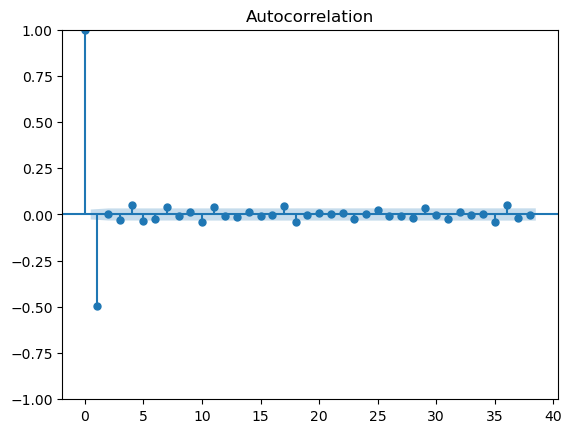

In [8]:
# plot acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(diff_log_data)
plt.show()

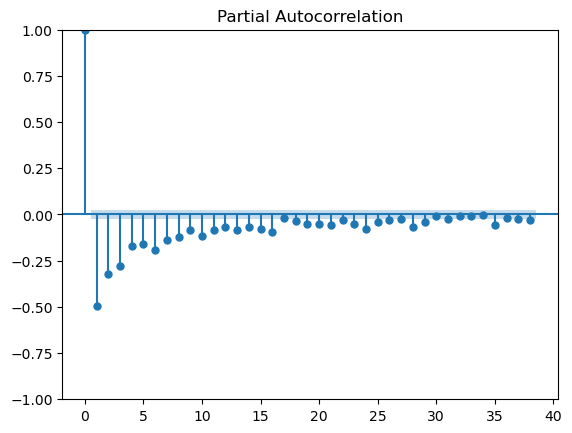

In [9]:
plot_pacf(diff_log_data)
plt.show()

In [10]:
# model selection
maxp = 5
maxq = 5
best_aic = np.inf
best_order = None
aics = np.zeros((maxp + 1, maxq + 1))

for p in range(maxp + 1):
    for q in range(maxq + 1):
        try:
            model = ARIMA(diff_log_data, order=(p, 0, q)).fit(method="innovations_mle")
            aics[p, q] = model.aic
            if aics[p, q] < best_aic:
                best_aic = aics[p, q]
                best_order = (p, 0, q)
        except:
            pass

d:\ProgramFiles\miniconda\envs\common\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\ProgramFiles\miniconda\envs\common\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\ProgramFiles\miniconda\envs\common\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\ProgramFiles\miniconda\envs\common\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\ProgramFiles\miniconda\envs\common\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported inde

In [11]:
print("Best AIC: ", best_aic)
print("Best order: ", best_order)

# print the table of aic
df = pd.DataFrame(aics)
df.index.name = "p"
df.columns.name = "q"
display(df)

Best AIC:  -30338.307307389827
Best order:  (5, 0, 3)


q,0,1,2,3,4,5
p,,,,,,
0,-26587.503777,-30314.198531,-30312.788873,-30312.417232,-30318.406891,-30316.529250
1,-28087.973628,-30312.766487,-30311.450248,-30308.974865,-30318.658414,-30315.671135
2,-28661.049317,-30312.519875,-30308.967997,-30306.580007,-30325.330556,-30326.691501
3,-29081.188203,-30316.991570,-30317.381156,-30325.277510,-30332.608656,-30317.595737
4,-29232.869667,-30315.534071,-30314.517870,-30318.548045,-30317.579774,-30311.434822
5,-29367.358890,-30327.254234,-30328.187184,-30338.307307,-30336.367938,-30313.834161


In [12]:
# best_order = (3, 0, 4)
model = ARIMA(diff_log_data, order=best_order).fit(method="innovations_mle")
model.summary()

d:\ProgramFiles\miniconda\envs\common\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\ProgramFiles\miniconda\envs\common\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\ProgramFiles\miniconda\envs\common\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Closing price   No. Observations:                 5317
Model:                 ARIMA(5, 0, 3)   Log Likelihood               15179.154
Date:                Sat, 04 May 2024   AIC                         -30338.307
Time:                        18:56:54   BIC                         -30272.521
Sample:                             0   HQIC                        -30315.322
                               - 5317                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.134e-08   1.41e-07      0.647      0.518   -1.86e-07    3.68e-07
ar.L1          0.2574      0.040      6.384      0.000       0.178       0.336
ar.L2         -0.8481      0.037    -22.891      0.000      -0.921      -0.776
ar.L3         -0.0399      0.012     -3.209      0.001      -0.064      -0.016
ar.L4          0.0044      0.010      0.456      0.648      -0.015       0.023
ar.L5         -0.0700      0.009     -8.104      0.000      -0.087      -0.053
ma.L1         -1.2681      0.039    -32.647      0.000      -1.344      -1.192
ma.L2          1.1045      0.057     19.395      0.000       0.993       1.216
ma.L3         -0.8362      0.037    -22.765      0.000      -0.908      -0.764
sigma2         0.0002   2.22e-06     87.434      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5130.74
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
forecasts = model.get_forecast(steps=365)
display(forecasts.summary_frame())

d:\ProgramFiles\miniconda\envs\common\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\ProgramFiles\miniconda\envs\common\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Closing price,mean,mean_se,mean_ci_lower,mean_ci_upper
5317,-9.547156e-03,0.013919,-0.036828,0.017734
5318,7.025574e-04,0.019790,-0.038085,0.039490
5319,1.790989e-03,0.019790,-0.036996,0.040578
5320,-1.329293e-03,0.019792,-0.040121,0.037462
5321,-1.664956e-03,0.019801,-0.040474,0.037144
...,...,...,...,...
5677,9.134288e-08,0.019850,-0.038906,0.038906
5678,9.134288e-08,0.019850,-0.038906,0.038906
5679,9.134288e-08,0.019850,-0.038906,0.038906
5680,9.134288e-08,0.019850,-0.038906,0.038906


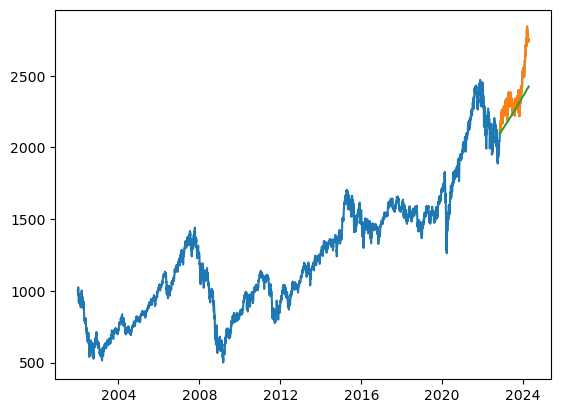

In [14]:
diff2 = log_data.iloc[-1] - log_data.iloc[-2]
diff1 = log_data.iloc[-1]

recovered_forecasts = np.cumsum(np.cumsum(forecasts.predicted_mean) + diff2) + diff1
recovered_forecasts += np.polyval(poly, np.arange(len(log_data), len(log_data) + 365))

plt.plot(all_data["Date"], all_data["Closing price"])
plt.plot(all_data["Date"].tail(365), validation_data)
plt.plot(all_data["Date"].tail(365), np.exp(recovered_forecasts))

plt.show()

### Residual

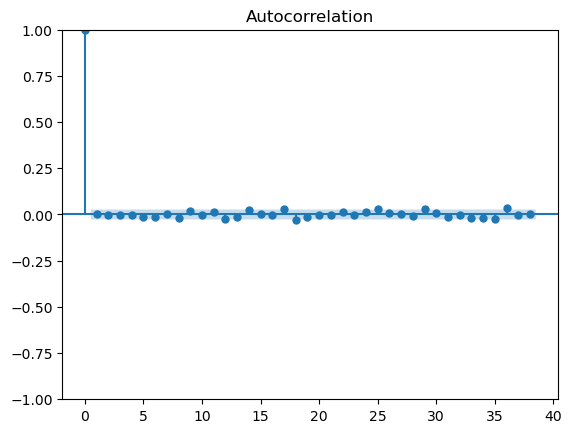

In [15]:
resid = model.resid

plot_acf(resid)
plt.show()

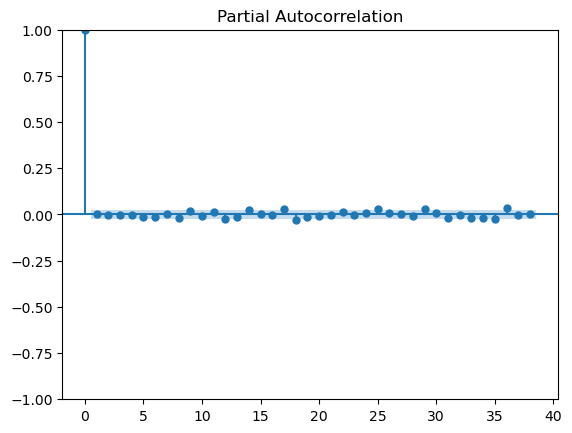

In [16]:
plot_pacf(resid)
plt.show()

## Apply ARIMA(p, 2, q)

In [17]:
# model selection
best_aic = np.inf
best_order = None
aics = np.zeros((maxp + 1, maxq + 1))

for p in range(maxp + 1):
    for q in range(maxq + 1):
        try:
            model = ARIMA(log_data, order=(p, 2, q)).fit(method="innovations_mle")
            aics[p, q] = model.aic
            if aics[p, q] < best_aic:
                best_aic = aics[p, q]
                best_order = (p, 2, q)
        except:
            pass


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17384\1138557698.py:9: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  model = ARIMA(log_data, order=(p, 2, q)).fit(method="innovations_mle")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17384\1138557698.py:9: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  model = ARIMA(log_data, order=(p, 2, q)).fit(method="innovations_mle")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17384\1138557698.py:9: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  model = ARIMA(log_data, order=(p, 2, q)).fit(method="innovations_mle")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17384\1138557698.py:9: UserWarning: Provided `endog` series has been differenced to eliminate integration 

In [18]:
print("Best AIC: ", best_aic)
print("Best order: ", best_order)

# print the table of aic
df = pd.DataFrame(aics)
df.index.name = "p"
df.columns.name = "q"
display(df)

Best AIC:  -30330.047595188917
Best order:  (5, 2, 3)


q,0,1,2,3,4,5
p,,,,,,
0,-26589.501915,-30313.241273,-30311.759413,-30311.583591,-30317.271939,-30315.767073
1,-28089.973540,-30311.754948,-30310.375608,-30310.533562,-30310.825887,-30315.604830
2,-28663.049316,-30311.467399,-30310.532369,-30322.276284,-30326.088081,-30326.958489
3,-29083.188188,-30316.094206,-30310.756766,-30326.058774,-30328.366374,-30326.022552
4,-29234.869575,-30314.576265,-30313.213961,-30326.868668,-30324.606754,-30307.066615
5,-29369.358668,-30326.308860,-30312.526392,-30330.047595,-30308.551242,-30309.632244


In [19]:
# best_order = (3, 2, 4)
model = ARIMA(log_data, order=best_order).fit(method="innovations_mle")
model.summary()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17384\1075475470.py:2: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  model = ARIMA(log_data, order=best_order).fit(method="innovations_mle")


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Closing price   No. Observations:                 5319
Model:                 ARIMA(5, 2, 3)   Log Likelihood               15174.024
Date:                Sat, 04 May 2024   AIC                         -30330.048
Time:                        18:57:51   BIC                         -30270.840
Sample:                             0   HQIC                        -30309.361
                               - 5319                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8530      0.010    -87.371      0.000      -0.872      -0.834
ar.L2         -1.0183      0.012    -86.180      0.000      -1.041      -0.995
ar.L3         -0.0606      0.014     -4.197      0.000      -0.089      -0.032
ar.L4         -0.0403      0.011     -3.668      0.000      -0.062      -0.019
ar.L5         -0.0312      0.009     -3.588      0.000      -0.048      -0.014
ma.L1         -0.1556      0.011    -14.093      0.000      -0.177      -0.134
ma.L2          0.1515      0.009     16.204      0.000       0.133       0.170
ma.L3         -0.9956      0.011    -90.507      0.000      -1.017      -0.974
sigma2         0.0002      3e-06     64.722      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5207.75
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
forecasts = model.get_forecast(365).summary_frame()
display(forecasts)

Closing price,mean,mean_se,mean_ci_lower,mean_ci_upper
5319,0.042740,0.013934,0.015429,0.070050
5320,0.043549,0.019628,0.005078,0.082020
5321,0.042623,0.023893,-0.004206,0.089452
5322,0.041905,0.027245,-0.011494,0.095304
5323,0.043182,0.030285,-0.016176,0.102539
...,...,...,...,...
5679,0.044744,0.282718,-0.509373,0.598861
5680,0.044864,0.283193,-0.510185,0.599913
5681,0.044970,0.283670,-0.511012,0.600952
5682,0.044780,0.284144,-0.512132,0.601693


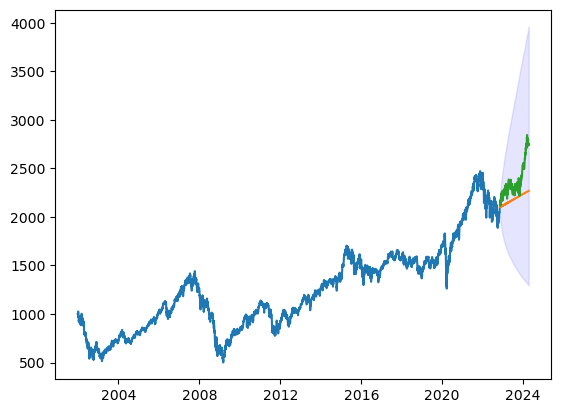

In [21]:
recovered_mean = forecasts["mean"] + np.polyval(poly, np.arange(len(log_data), len(log_data) + 365))
recovered_ci_lower = forecasts["mean_ci_lower"] + np.polyval(poly, np.arange(len(log_data), len(log_data) + 365))
recovered_ci_upper = forecasts["mean_ci_upper"] + np.polyval(poly, np.arange(len(log_data), len(log_data) + 365))

plt.plot(all_data["Date"].head(-365), np.exp(log_data + np.polyval(poly, np.arange(len(log_data)))))
plt.plot(all_data["Date"].tail(365), np.exp(recovered_mean))
plt.plot(all_data["Date"].tail(365), validation_data)
plt.fill_between(all_data["Date"].tail(365), np.exp(recovered_ci_lower), np.exp(recovered_ci_upper), color='b', alpha=0.1)
plt.show()

### Residual

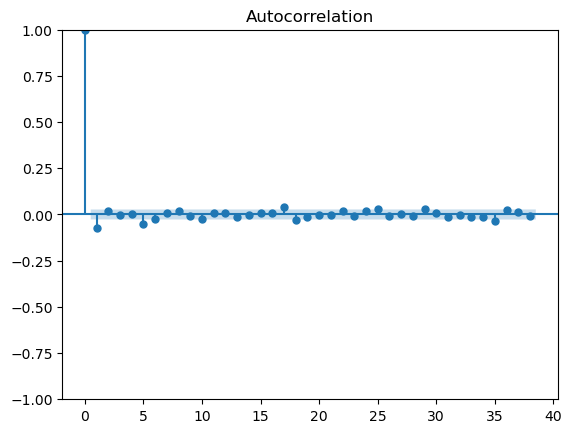

In [22]:
resid = model.resid
plot_acf(resid)
plt.show()

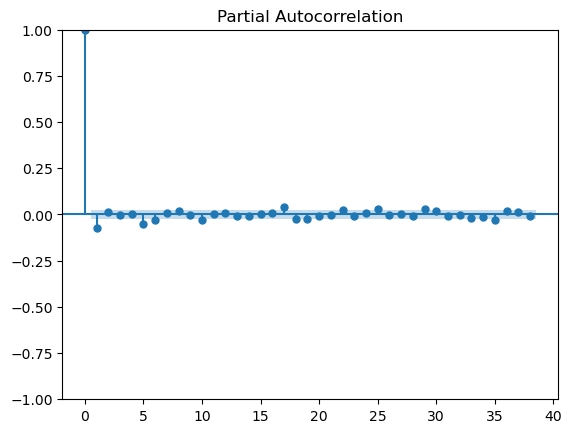

In [23]:
plot_pacf(resid)
plt.show()